In [66]:
from core.search.query_paper import author_paper_query
from core.search.query_paper import conference_paper_query
from core.search.query_paper import journal_paper_query

from graph.config import conf
from core.utils.entity_type import Entity_type

from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search

import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Target
author_ids     = ["2100918400"]
conference_ids = []
journal_ids    = []
paper_ids      = []

In [17]:
# Get paper ids
total_paper = author_paper_query(author_ids) + conference_paper_query(conference_ids) \
    + journal_paper_query(journal_ids) + paper_ids

[]


In [59]:
# Get field of study
fos_dict = dict()

# Elastic search client
client = Elasticsearch(conf.get("elasticsearch.hostname"))

search = Search(index = "paperfieldsofstudy", using = client)
search = search.query('terms', PaperId = total_paper)
#search = Search.filter('term', {"range": {"Similarity": {"gt": 0}}})
search = search.source(['PaperId', 'FieldOfStudyId', 'Similarity'])

for res in search.scan():
    if not res['Similarity'] > 0:
        continue
    
    cur_fos = res['FieldOfStudyId']
    if cur_fos in fos_dict:
        fos_dict[cur_fos].append((res['PaperId'], res['Similarity']))
    else:
        fos_dict[cur_fos] = list()
        fos_dict[cur_fos].append((res['PaperId'], res['Similarity']))
        
for val in fos_dict.values():
    val.sort(key = lambda x: -x[1])

In [97]:
# Field of study names
fos_name_dict = dict()

# Elastic search client
client = Elasticsearch(conf.get("elasticsearch.hostname"))

search = Search(index = "fieldsofstudy", using = client)
search = search.query('terms', FieldOfStudyId = list(fos_dict.keys()))
search = search.source(['FieldOfStudyId', 'DisplayName'])

for res in search.scan():
    fos_name_dict[res['FieldOfStudyId']] = res['DisplayName']

In [170]:
# Add fos names
new_fos_dict = dict()
for fos, vals in fos_dict.items():    
    new_fos_dict[fos_name_dict[fos]] = vals
    
fos_dict = new_fos_dict

In [165]:
# Constants
sim_threshold = 0
top = 20
ignore_top = True

In [172]:
# Threshold fos
pie_vals = list()
pie_fos_dict = dict()
for fos, vals in fos_dict.items():
    filtered_vals = [y for (x, y) in vals if y > sim_threshold]
    
    if filtered_vals:
        pie_vals.append((fos, np.sum(filtered_vals)))
        pie_fos_dict[fos] = filtered_vals

pie_vals.sort(key = lambda x: -x[1])

if top:
    take_pie_vals = pie_vals[:top]
    if not ignore_top:
        take_pie_vals.append(('Other', np.sum([x[1] for x in pie_vals[top:]])))
    pie_vals = take_pie_vals
    
        

pie_scores = [x[1] for x in pie_vals]
pie_labels = ["{}, ({:.3f})".format(x[0], x[1]) for x in pie_vals]
bar_labels = [x[0] for x in pie_vals]

#pie_labels = [x[0] for x in pie_vals]

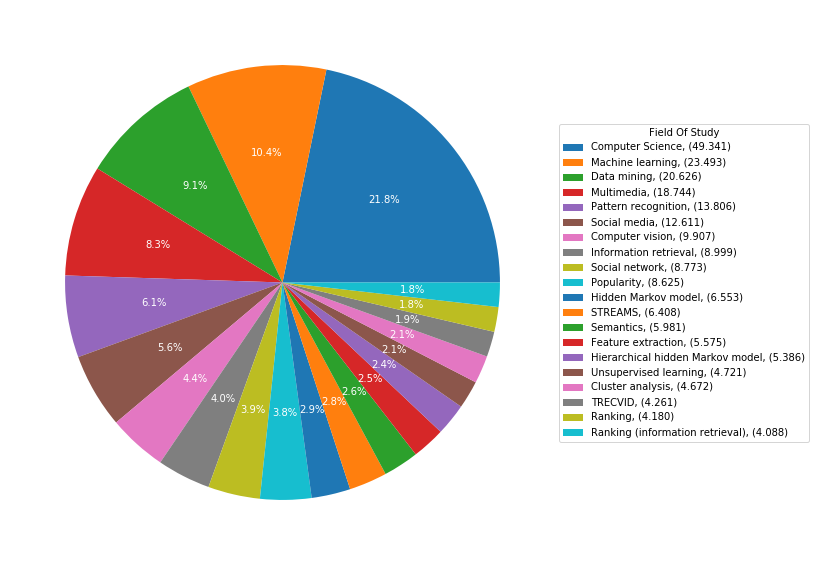

In [167]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))
                       
wedges, texts, autotexts = ax.pie(pie_scores, autopct=lambda pct: "{:.1f}%".format(pct),
       textprops=dict(color="w"))

ax.legend(wedges, pie_labels,
          title="Field Of Study",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

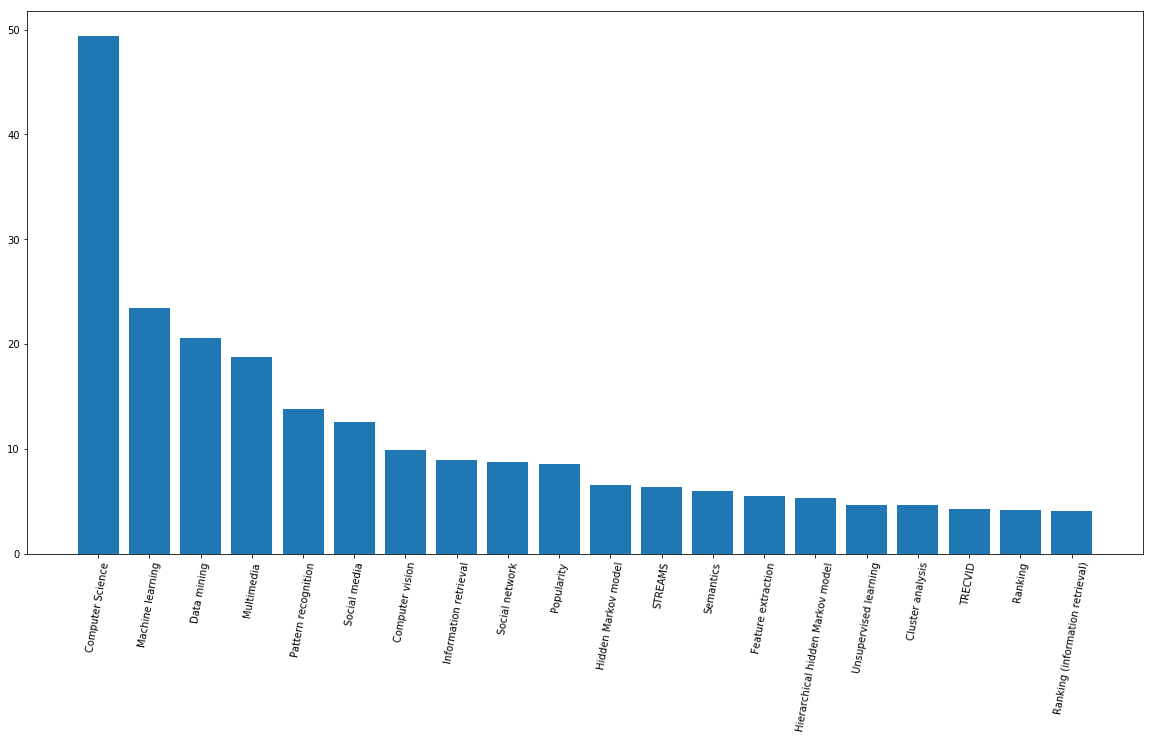

In [171]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.bar(bar_labels, pie_scores)
plt.xticks(rotation=80, ha='center', va='top')

plt.show()

Total Entries: 43


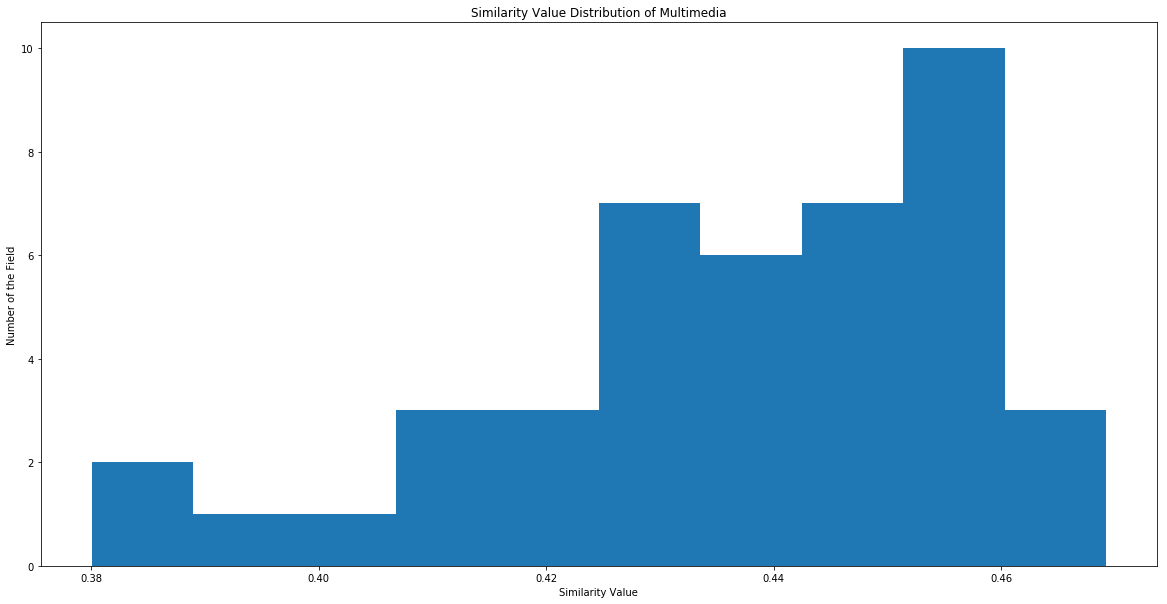

In [201]:
# Get distribution of fos
fig, ax = plt.subplots(figsize=(20, 10))

fos_name = bar_labels[3]
num_bins = 10

n, bins, patches = plt.hist(pie_fos_dict[fos_name], num_bins)

plt.title('Similarity Value Distribution of {}'.format(fos_name))
plt.xlabel('Similarity Value')
plt.ylabel('Number of the Field')

print("Total Entries: {}".format(len(pie_fos_dict[fos_name])))

plt.show()